# Model Predictive Control
Model predictive control (MPC) is an advanced concept for feedback control of a digital control system leveraging computational power and accurate modeling. The general idea in MPC is to solve an optimization problem anew at each timestep, making use of the just-received feedback data from sensors. The processor of the computer that updates the input signal to the plant must be able to solve this optimization problem within the time duration of one timestep, so the optimization problem cannot be too complex. The optimization problem can even be generalized to find the values of multiple controlled inputs to the plant for multivariable control, handled in a single computer program. 

In this notebook we will see how a single time step’s control update is calculated. We’ll use a simple linear system as our plant. This system was used for the controller proposed by E. B. Dahlin [1].

We start with a linear model of the plant, $G$:

$$G=\frac{1}{15s^2 + 8s + 1}$$

This differential equation could describe a physical mass-spring-damper mechanical system or a resistor-inductor-capacitor (RLC) circuit electrical system or other second-order linear systems. From the coefficients, we can determine that this is a stable and overdamped system. An instantaneous step up in the input signal u(t) from 0 to 1 will take about 20 seconds for our system to respond by moving from 0 to 0.95, which is almost 1. Adding a feedback controller such as MPC can make the controlled “closed-loop” system to have a faster response to a step change in its input signal than the uncontrolled “open-loop” system.


Let us specify that this is indeed a mass-spring-damper mechanical system, initially at equliibrium
$$ x(0) = 0 $$
$$ \dot{x}(0) = 0 $$
$$ 15 \ddot{x} + 8 \dot{x} + 1 x = 1 f $$
where $x$ is displacement in meters and $f$ is force in newtons.
Note that there must be units on some of the coefficients (15, 8, 1, and 1), so let's show them as well:
$$\left ( 15 \rm kg \it \right ) \ddot{x} + \left(8\rm\frac{N}{m/s}\it\right) \dot{x} + \left(1\rm\frac{N}{m}\it\right) x = 1 f $$
The units are helpful for understanding the system, but controls engineers often drop the units once they are satisfied that the units are consistent. We will use traditional variables of a control system. Let the plant input be denoted $u(t) = f(t)$, so the input signal is force, for example, from a voice coil motor or linear motor. Let the plant output be denoted $y(t) = x(t)$. The state $x$ is also the output of this plant. We rewrite the plant equation as:
$$ 15 \ddot{y} + 8 \dot{y} + 1 y = 1 u $$
We are about to implement a step repsonse of the system using a unit step input signal, which we denote $1(t)$, although ohter references use $H(t)$ as a Heaviside funciton or sometimes use the letter u in the notation for unit step signal.
$$1(t) =    
\begin{cases}
    1,& \text{if } t\geq 0\\
    0,              & \text{otherwise}
\end{cases}
$$

#### Press ▶️ to plot the step response of our linear system $G$.

Operation Complete


Text(0.5, 1.0, 'unit step response of $G$ for $u(t)=1(t)$')

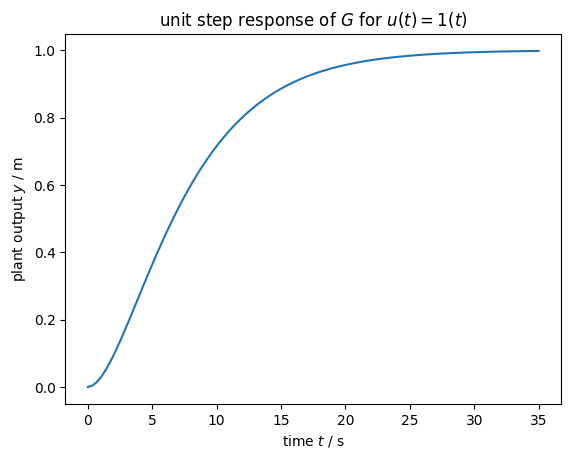

In [6]:
import numpy
import scipy.signal
import scipy.optimize
import matplotlib.pyplot as plt # it is common in Python to import a library with an alias such as "plt" to make programming simpler

G = scipy.signal.lti([1], [15, 8, 1]) # the coefficients of the numerator (1) and denominator (15,8, and 1) are here
plt.plot(*G.step()) # this line plots the unit step response

print('Operation Complete')
plt.xlabel('time $t$ / s')
plt.ylabel('plant output $y$ / m')
plt.title('unit step response of $G$ for $u(t)=1(t)$')

We see some imporant details of the unit step response. The inital output is 0 with an initial slope of 0. This agrees with our assumptions. There is no overshoot of the system response, which agrees with our earlier finding that the system is over-damped. The system is quite slow. It takes around 20 seconds to raise its output from 0 to 0.95.

Our goal is to find out what manipulations must be made (changes to 
) in order to get the system to follow a specific desired trajectory (which we will call 
 for the reference trajectory). We will allow the controller to make a certain number of moves. This is called the control horizon, 
. We will the observe the effect of this set of moves (called a “move plan”) for time called the prediction horizon (
).


### Controller parameters

We define the controller parameters with a control horizon (the number of time steps that the controller predicts ahead in solving its optimization problem), a prediction horizon (the number of time steps ahead that we will simulate to evaluate controller performance), and a sampling rate, in this case 1 second. 

#### Press ▶️ to define control and prediction horizons, set the sampling rate, and generate time points for continuous and discrete representations over the prediction horizon.

In [ ]:
M = 10  # Control horizon
P = 20  # Prediction horizon
DeltaT = 1  # Sampling rate

tcontinuous = numpy.linspace(0, P*DeltaT, 1000)  # some closely spaced time points
tpredict = numpy.arange(0, P*DeltaT, DeltaT)   # discrete points at prediction horizon
print('Operation Complete')

To design a model predictive controller, we must have a desired behavior of the system. We will design by looking at step response behavior of the system. If we select a perfect step response as our reference, we will have difficulty evaluating the controller because that response is not physically achievable. A mass cannot be moved a displacement instantaneously without infinite energy. Instead of dealing in the infinite, let us use a reference trajectory for our system which is achievable: a first order system response. We choose a time constant tau_c for a desired first order response. Recall that a first order system reaches about 95% of its full step response in a period of time equal to about three times the time constant. If we set tau_c to 1, then we expect a response of our system to 95% in 3 seconds, which is fast compared to the 20 seconds we saw above for the open-loop system.

#### Press ▶️ to calculate the response curve based on a time constant and the exponential decay formula.

In [ ]:
tau_c = 1
r = 1 - numpy.exp(-tpredict/tau_c)
print('Operation Complete')

Now we build a model predictive controller. This controller solves an optimization problem before updating the input signal to the plant. This occurs once at every timestep at the selected speed for implementation of the controller. We will build out the ability to test the controller’s input signal, (t) here. 
We start with an array u(t) containing M elements as the controller predicts the next M timesteps when solving its optimization.

Next, we set the initial state x(t=0)=x_0 of the system to 0 as the predictions are for step responses away from an initial equilibrium at 0.

#### Press ▶️ to create an array of control inputs initialized to one for the specified control horizon.

In [ ]:
u = numpy.ones(M)
x0 = numpy.zeros(G.to_ss().A.shape[0])
print('Operation Complete')

Now, we define functions which will be useful for our controller and simulations. The extend function takes the input signal array (signal for each of the next M timesteps) as its argument and extends or concatenates the array with values of u at timestep M in the future as (u[-1], the final value of u returns 1) as the prediction will assume that the controller has turned off the input after M timesteps. We don’t store the extended u in a variable at this time, but instead return it as the returned value of the function.

#### Press ▶️ to extend the control input array, simulate the system response, and plot the predicted output over the prediction horizon.

The prediction function uses the linear system simulation function “lsim” to predict the response of the linear system, in this case, a controlled “closed loop” system to the extended input signal and the initial state of the system.

In [ ]:
def prediction(u, t=tpredict, x0=x0):
    """Predict the effect of an input signal"""
    t, y, x = scipy.signal.lsim(G, u, t, X0=x0, interp=False)
    return y

In [ ]:
def extend(u):
    """We optimise the first M values of u but we need P values for prediction"""
    return numpy.concatenate([u, numpy.repeat(u[-1], P-M)])

plt.plot(tpredict, prediction(extend(u)))
print('Operation Complete')

#### Press ▶️ to define a function that computes the objective value by evaluating the squared error between the predicted and desired responses.

In [ ]:
def objective(u, x0=x0):
    """Calculate the sum of the square error for the cotnrol problem"""
    y = prediction(extend(u))
    return sum((r - y)**2)
print('Operation Complete')

#### Press ▶️ to obtain the value of the objective for our step input:

In [ ]:
objective(u)

Now we figure out a set of moves which will minimize our objective function as the result of an optimization problem. Literally, we finding the u signal to minimizing the objective function

#### Press ▶️ to get a set of moves which will minimise our objective function

In [ ]:
result = scipy.optimize.minimize(objective, u)
uopt = result.x
result.fun

#### Press ▶️ to resample the discrete output to continuous time, effectively working out the zero-order hold value.

In [ ]:
ucont = extend(uopt)[((tcontinuous-0.01)//DeltaT).astype(int)]
print('Operation Complete')

#### Press ▶️ to plot the move plan and the output. Notice that we are getting exactly the output we want at the sampling times. At this point we have effectively recovered the controller of [1].

In [ ]:
def plotoutput(ucont, uopt):
    plt.figure()
    plt.plot(tcontinuous, ucont)
    plt.xlim([0, DeltaT*(P+1)])
    plt.figure()
    plt.plot(tcontinuous, prediction(ucont, tcontinuous), label='Continuous response')
    plt.plot(tpredict, prediction(extend(uopt)), '-o', label='Optimized response')
    plt.plot(tpredict, r, label='Set point')
    plt.legend()

plotoutput(ucont, uopt)
print('Operation Complete')

One of the reasons for the popularity of MPC is how easy it is to change its behavior using weights in the objective function. Try using this definition instead of the simple one above and see if you can remove the ringing in the controller output.

#### Press ▶️ to modify the behavior of the MPC by adjusting weights in the objective function, aiming to eliminate ringing in the controller output.

In [ ]:
def objective(u, x0=x0):
    y = prediction(extend(u))
    umag = numpy.abs(u)
    constraintpenalty = sum(umag[umag > 2])
    movepenalty = sum(numpy.abs(numpy.diff(u)))
    strongfinish = numpy.abs(y[-1] - r[-1])
    return sum((r - y)**2) + 0*constraintpenalty + 0.1*movepenalty + 0*strongfinish

objective(u, x0=x0)

You should find that this controlled system has slow response, but no high frequency ringing.

So we have seen that the controller can decide what to use as its next input signa, u(1). To move forward with our feedback control system, we would write a loop to continue the process of optimization at each timepoint moving forward, taking the output of the system at that time point as the new initial condition.

[1] Dahlin, E. B., Designing and Tuning Digital Controllers, Instrum. Control Systems, 41 (6), 77  (1968).